In [ ]:
# You may want to install "gprof2dot"
import io
from collections import Counter
import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import pydot

import warnings
warnings.filterwarnings('ignore')

eps = 1e-5  # a small number


**4.1  Implement Decision Trees**

In [ ]:
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, flag = None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.flag = flag

    @staticmethod
    def entropy(y):

        if  len(y) ==0 :
            return 0
        p_l = len(np.where(y<0.5)[0])/len(y) ;p_r  = 1-p_l;
        H_s = - p_l* np.log2(p_l + eps) - p_r* np.log2(p_r+eps)
        return  H_s

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO: implement information gain function

        H_s = DecisionTree.entropy(y)
        s_l = y[np.where(X < thresh)[0]]
        s_r = y[np.where(X >= thresh)[0]]
        H_sl = DecisionTree.entropy(s_l)
        H_sr = DecisionTree.entropy(s_r)
        H_after = (len(s_l)*H_sl + len(s_r)*H_sr ) / (len(s_l) +len(s_r))

        return H_s - H_after

    @staticmethod
    def gini(y):

        if  len(y) ==0 :
            return 0

        p_l = len(np.where(y<0.5)[0])/len(y) ;p_r  = 1-p_l;

        return 1 - p_l**2 -p_r**2


    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO: implement gini impurity function

        H_s = DecisionTree.gini(y)

        s_l = y[np.where(X < thresh)[0]]
        s_r = y[np.where(X >= thresh)[0]]

        H_sl = DecisionTree.gini(s_l)
        H_sr = DecisionTree.gini(s_r)

        H_after = (len(s_l)*H_sl + len(s_r)*H_sr ) / (len(s_l) +len(s_r))

        return H_s - H_after
        #pass

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        new_m = int((X.shape[1])**0.5)
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                #np.linspace(np.min(X[:,new_m]) + eps, np.max(X[:, new_m]) - eps, num=10)
                for i in range(X.shape[1])
            ])

            if self.flag:

                feature_size = int((X.shape[1])**0.5)
                random_columns = np.random.choice(X.shape[1],feature_size ,replace=False)
                for i in random_columns:
                    # gains.append([self.gini_impurity(X[:, i], y, t) for t in thresh[i, :]])
                    gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            else:
                for i in range(X.shape[1]):
                # gains.append([self.gini_impurity(X[:, i], y, t) for t in thresh[i, :]])
                    gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self





    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())


**4.2 Implement a Random Forest**

In [ ]:
class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n=200,max_depth = 5, features=None):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        #self.flag = flag
        self.decision_trees = [
            DecisionTree(max_depth=max_depth, feature_labels=features)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # TODO: implement function
        for tree in self.decision_trees:

            random_indexs = np.random.choice(len(y),X.shape[0])

            sub_sample = X[random_indexs]; sub_y = y[random_indexs]

            tree.fit(sub_sample,sub_y)

            #pass

    def predict(self, X):
        # TODO: implement function
        pred_hist = []

        for tree in self.decision_trees:
            pred = tree.predict(X)
            pred_hist.append(pred)

        pred_n = np.vstack(pred_hist)
        major_pred =stats.mode(pred_n).mode[0]
        return major_pred
        #pass


In [ ]:
class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200,max_depth = 5,flag = True, feature_labels = None):# m=1,

        if params is None:
            params = {}
        # TODO: implement function
        self.max_depth = max_depth
        self.n = n
        self.flag =flag
        self.features = feature_labels

        self.decision_trees =[DecisionTree(max_depth=max_depth,feature_labels=feature_labels) for i in range(self.n)]



**4.3 Describe implementation details**

**Kaggle username: zwang108**
**Spam     score : 0.83236**
**Titanic  score : 0.78709**


1. How did you deal with categorical features and missing values?

    For categorical features, I have used one_hot encoding to transform unique values into new columns.And for missing values, I replaced missing data with the mode value.

2. What was your stopping criterion?
    My stopping criteria are based on the performance of training accuracy and validation accuracy at different depths. Because decision tree and random forest can easily overfit, we need to find the appropriate max_depth based on training accuracy and validation accuracy to prevent overfitting.


3. How did you implement random forests?
    a. I used BaggedTrees to help me create 200 random subtrees，then fit these 200 subsapmles into the Decision Tree

    b. At each tree node, m feature samples are randomly selected, that is, the square root of the total number of features

    c. Then get predictions for these 200 subsamples, concatenate them to get majority vote for each row.
    

4. Did you do anything special to speed up training?
    a. Limit tree depth
    
    b. For speed up teaining, after I used one-hot to transformed categorical features to new columns, I drop the orginal categorical features columns. It runs significantly faster than the previous one. (46.3s VS 1m0.2s)


5. Anything else cool you implemented?
    I preprocess Age and Fare features with binning, which would help reducing the noise and it also help increasing a little bit validation accuracy.


In [ ]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == '-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features

In [ ]:
path_train = './dataset/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
path_test = './dataset/titanic/titanic_test_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
y = data[1:, -1]  # label = survived
class_names = ["Died", "Survived"]
labeled_idx = np.where(y != '')[0]

y = np.array(y[labeled_idx])
titanic_y = y.astype(float).astype(int)


X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
titanic_X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert titanic_X.shape[1] == Z.shape[1]
titanic_features = list(data[0, :-1]) + onehot_features

In [ ]:
# reduce original categorical feature columns
try_titanic_X = titanic_X[:, [0,2,3,4,6,9,10,11,12,13]] #(999,10)
try_Z =Z[:, [0,2,3,4,6,9,10,11,12,13]]
try_titanic_features =[ titanic_features[index] for index in [0,2,3,4,6,9,10,11,12,13]]

# binning for age and fare
try_titanic_X[:, 1]=pd.qcut(try_titanic_X[:, 1], 4, labels=False)
try_titanic_X[:, 4]  =  pd.qcut(try_titanic_X[:, 4], 5, labels=False)
try_Z[:, 1]=pd.qcut(try_Z[:, 1], 4, labels=False)
try_Z[:, 4]  =  pd.qcut(try_Z[:, 4], 5, labels=False)


In [ ]:
spam_features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]
assert len(spam_features) == 32

# Load spam data
spam_path_train = './dataset/spam/spam_data.mat'
spam_data = scipy.io.loadmat(spam_path_train)
spam_X = spam_data['training_data']
spam_y = np.squeeze(spam_data['training_labels'])
spam_Z = spam_data['test_data']
spam_class_names = ["Ham", "Spam"]

**4.4 Performance Evaluation**

In [ ]:
def cross_val(X, y, features,classifier ):
    np.random.seed(0)

    index = np.random.permutation(X.shape[0]) # shuffle training index
    size = round(X.shape[0]*(1-0.2))
    X_train, X_val = X[index ][:size], X[index][size:]  # split dataset
    y_train, y_val=  y[index][:size], y[index][size:]

    max_depths = range(1,8)
    val_hist = []
    train_hist =[]

    score_val = dict()
    score_train = dict()

    for depth in max_depths:
         model = classifier(max_depth=depth, feature_labels=features)
         model.fit(X_train, y_train)
         val_predict = model.predict(X_val )
         y_val = y_val.reshape(-1,)

         train_predict = model.predict(X_train)
         y_train =y_train.reshape(-1,)

         val_acc = np.sum(val_predict == y_val) / len(y_val)
         val_hist.append(val_acc)
         score_val[depth] = val_acc

         train_acc = np.sum(train_predict == y_train) / len(y_train)
         train_hist.append(train_acc)
         score_train[depth] = train_acc

    optimal_depth = max_depths[val_hist.index(max(val_hist))]
    print('Optimal depth : ',optimal_depth,', training accuracy :', score_train[optimal_depth],
          ', validation accuracy :', max(val_hist))
    return max_depths[val_hist.index(max(val_hist))],max(val_hist)




In [ ]:
print("Titanic Decision Tree :")
titanic_dt = cross_val(try_titanic_X, titanic_y, try_titanic_features,DecisionTree)
print("\n"+"Titanic Random Forest :")
titanic_rf =cross_val(try_titanic_X, titanic_y, try_titanic_features,RandomForest)

Titanic Decision Tree :
Optimal depth :  4 , training accuracy : 0.8135168961201502 , validation accuracy : 0.79

Titanic Random Forest :
Optimal depth :  7 , training accuracy : 0.853566958698373 , validation accuracy : 0.79


In [ ]:
print("\n"+"Spam Decision Tree    :")
spam_dt = cross_val(spam_X, spam_y, spam_features,DecisionTree)
print("\n"+"Spam Random Forest    :")
spam_rf = cross_val(spam_X, spam_y, spam_features,RandomForest)


Spam Decision Tree    :
Optimal depth :  7 , training accuracy : 0.8383049242424242 , validation accuracy : 0.8304924242424242

Spam Random Forest    :
Optimal depth :  7 , training accuracy : 0.8390151515151515 , validation accuracy : 0.8276515151515151


In [ ]:
def prediction_to_csv(X, y,Z,features,classifier,dataset): #RandomForest
    dt = classifier(max_depth=7, feature_labels=features)
    dt.fit(X, y)
    y_pred = dt.predict(Z)
    y_test = y_pred.astype(int)

    df = pd.DataFrame({'Category': y_test})
    df.index += 1
    df.to_csv(dataset +'_submission.csv', index_label='Id')


In [ ]:
prediction_to_csv(spam_X, spam_y,spam_Z,spam_features,RandomForest,'Spam')

In [ ]:
prediction_to_csv(try_titanic_X, titanic_y,try_Z,try_titanic_features,RandomForest,'Titanic')


**4.5 Writeup Requirements for the Spam Dataset**

# 4.5.2
(a) ('exclamation) <= 0.5
(b) ('money') <= 0.5
(c) ('parenthesis') <= 0.5
(d) ('creative') > 0.5
(e) Therefore this email was spam.

(a) ('exclamation) > 0.5
(b) ('money') <= 0.5
(c) ('parenthesis') <= 0.5
(d) ('ampersand') > 0.5
(e) Therefore this email was ham.

In [ ]:
dataset = "Spam"
clf = sklearn.tree.DecisionTreeClassifier(max_depth = 4,min_samples_leaf= 10,random_state=0)
clf.fit(spam_X, spam_y)
out = io.StringIO()

# You may want to install "gprof2dot"
sklearn.tree.export_graphviz(
    clf, out_file=out, feature_names=spam_features, class_names=spam_class_names)
graph = pydot.graph_from_dot_data(out.getvalue())
pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

# 4.5.3
It has the highest validation accuracy when the depth is 16.

From the plot, we can observe that the validation accuracy increases as the depth increases until the depth is 16, then the accuracy starts to decrease until the depth is 32, after that the accuracy remains the same. As the depth of the tree increases, so does the complexity of the model and the validation accuracy increases until depth is 16, after that the decision tree model starts to overfit, and the validation accuracy begins to decrease.

In [ ]:
def cross_val_depth(X, y, features,depth_list,classifier):
    np.random.seed(0)

    index = np.random.permutation(X.shape[0]) # shuffle training index
    size = round(X.shape[0]*(1-0.2))
    X_train, X_val = X[index ][:size], X[index][size:]  # split dataset
    y_train, y_val=  y[index][:size], y[index][size:]

    val_hist = []

    for depth in depth_list:
         model = classifier(max_depth=depth, feature_labels=features)
        # model = DecisionTree(max_depth=depth, feature_labels=features)
        # model = RandomForest(max_depth=depth, feature_labels=features,flag = True)
         model.fit(X_train, y_train)
         val_predict = model.predict(X_val )
         y_val = y_val.reshape(-1,)
         val_acc = np.sum(val_predict == y_val) / len(y_val)
         val_hist.append(val_acc)
    return val_hist

In [ ]:
import matplotlib.pyplot as plt
def make_plot(train_his,data_name, train_num,name):
    plt.figure(figsize=[5,5])
    plt.plot( train_num,train_his,'b',linewidth=1.0)
    plt.legend([name],fontsize=12)
    plt.xlabel('Number of Depths  ',fontsize=16)
    plt.ylabel('Validation Accuracy ',fontsize=16)
    plt.title("Validation Accuracy VS. N0. Depths " +data_name,fontsize=16)

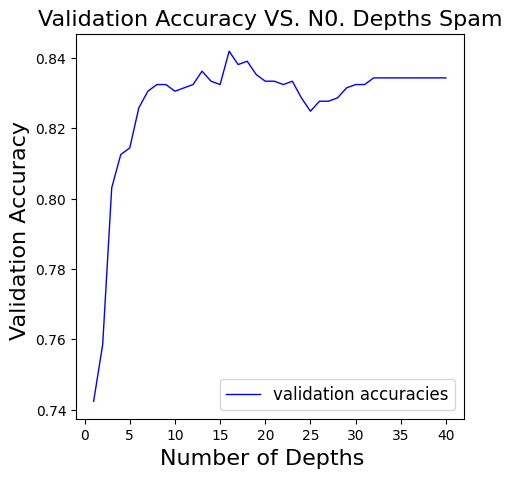

In [ ]:
train_num =  range(1,41)
spam_val_hist = cross_val_depth(spam_X, spam_y,spam_features,train_num,DecisionTree)
make_plot(spam_val_hist,'Spam', train_num,'validation accuracies')


**4.6 Writeup Requirements for the Titanic Dataset**

(a) ('female') <= 0.5
(b) ('pclass') <= 1.5
(c) Therefore this person was Died.

(a) ('female') > 0.5
(b) ('pclass') > 2.5
(c) ('S') <= 0.5
(d) Therefore this person was Survived.


In [ ]:
dataset = "Titanic"

clf1 = sklearn.tree.DecisionTreeClassifier(max_depth = 3,min_samples_leaf= 8,random_state=0)
clf1.fit(try_titanic_X, titanic_y)
out = io.StringIO()

# You may want to install "gprof2dot"
sklearn.tree.export_graphviz(
    clf1, out_file=out, feature_names=try_titanic_features, class_names=class_names)
graph = pydot.graph_from_dot_data(out.getvalue())
pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)